<a href="https://colab.research.google.com/github/Jiya9304/AIMLMonth2023/blob/main/Counterfeit_Medicines_using_Pill_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Install Required Libraries

In [ ]:
!pip install --quiet gdown opencv-python-headless albumentations tensorflow

#2. Download & Extract Data

In [ ]:
import gdown
import zipfile
import os

In [ ]:
# Google Drive File ID
file_id = '1kS3D4_9B7zFOT8QPQe2g-oxyxqT1BR-7'
url = f'https://drive.google.com/uc?id={file_id}'

In [ ]:
# Download the dataset zip
gdown.download(url, output='pill_dataset.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1kS3D4_9B7zFOT8QPQe2g-oxyxqT1BR-7
From (redirected): https://drive.google.com/uc?id=1kS3D4_9B7zFOT8QPQe2g-oxyxqT1BR-7&confirm=t&uuid=87c9e86d-3729-4369-a906-27ada1971961
To: /content/pill_dataset.zip
100%|██████████| 261M/261M [00:05<00:00, 48.8MB/s]


'pill_dataset.zip'

In [ ]:
# Unzip to folder
with zipfile.ZipFile('pill_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('pill_dataset')

 # 3. Verify File Paths


In [ ]:
print("Extracted dataset folders:", os.listdir('pill_dataset'))

Extracted dataset folders: ['data.yaml', 'test', 'valid', 'README.dataset.txt', 'train', 'README.roboflow.txt']


In [ ]:
# Define useful paths
base_dir = '/content/pill_dataset'
train_img_dir = os.path.join(base_dir, 'train/images')
train_lbl_dir = os.path.join(base_dir, 'train/labels')

val_img_dir = os.path.join(base_dir, 'valid/images')
test_img_dir = os.path.join(base_dir, 'test/images')

In [ ]:
# Count images per split
print(f"Train images: {len(os.listdir(train_img_dir))}")
print(f"Validation images: {len(os.listdir(val_img_dir))}")
print(f"Test images: {len(os.listdir(test_img_dir))}")

Train images: 4101
Validation images: 123
Test images: 65


# 4. Visualize a Sample Image

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Pick an image and its YOLO label file
img_file = os.listdir(train_img_dir)[0]
img_path = os.path.join(train_img_dir, img_file)
label_file = img_file.rsplit('.', 1)[0] + '.txt'
label_path = os.path.join(train_lbl_dir, label_file)


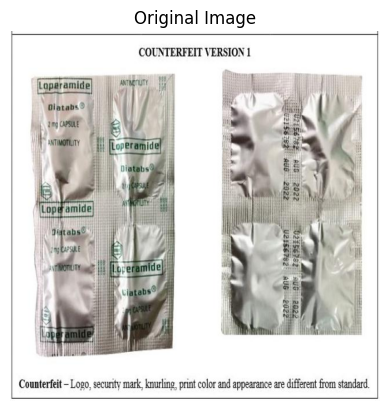

In [ ]:
# Read and show image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [ ]:
# Show label content (YOLO format: class xc yc w h)
with open(label_path, 'r') as f:
    print("Label file content:\n", f.read())

Label file content:
 1 0.25 0.49375 0.3890625 0.75390625
1 0.7625 0.4734375 0.3859375 0.74765625


#5. Count Object Instances

In [ ]:
class_counts = [0, 0]  # [authentic, counterfeit]

for label_file in os.listdir(train_lbl_dir):
    with open(os.path.join(train_lbl_dir, label_file), 'r') as f:
        for line in f:
            class_idx = int(float(line.strip().split()[0]))
            class_counts[class_idx] += 1

print(f"Total authentic objects: {class_counts[0]}")
print(f"Total counterfeit objects: {class_counts[1]}")

Total authentic objects: 6753
Total counterfeit objects: 568


#6. Find Images with Counterfeits

In [ ]:
counterfeit_images = []

for label_file in os.listdir(train_lbl_dir):
    with open(os.path.join(train_lbl_dir, label_file), 'r') as f:
        for line in f:
            if line.strip().split()[0] == '1':  # class 1 = counterfeit
                img_file = label_file.replace('.txt', '.jpg')
                if not os.path.exists(os.path.join(train_img_dir, img_file)):
                    img_file = label_file.replace('.txt', '.png')
                if os.path.exists(os.path.join(train_img_dir, img_file)):
                    counterfeit_images.append(img_file)
                break  # found, move on

print(f"Total images with at least one counterfeit: {len(counterfeit_images)}")
print("Sample counterfeit images:", counterfeit_images[:5])

Total images with at least one counterfeit: 168
Sample counterfeit images: ['1877_png.rf.dfaa0d0140b0ca836836febc6964c665.jpg', 'FDA-Advisory-No-2021-0363-1_png.rf.dd3de1fec7ab44644f74e0ae52a49df8.jpg', '109118801_3244498252272873_7164080379624931851_n_jpg.rf.835a9e920d3f92e7ff70c8962421e246.jpg', 'FDA-Advisory-No-2022-0477_2_png.rf.f7abb7fcde30d89f2be8a7b338774851.jpg', 'FDA-Advisory-No-2022-0611-20_png.rf.ff355f74723ca16969ca8b076b03c0ab.jpg']


#7. Visualize Image with Bounding Boxes

In [ ]:
import matplotlib.patches as patches

# Define class names
class_names = ['authentic', 'counterfeit']

In [ ]:
# Pick one counterfeit image
img_file = counterfeit_images[0]
img_path = os.path.join(train_img_dir, img_file)
label_file = img_file.rsplit('.', 1)[0] + '.txt'
label_path = os.path.join(train_lbl_dir, label_file)

In [ ]:
# Load image and labels
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

In [ ]:
# Convert YOLO to pixel boxes
boxes = []
with open(label_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        class_id = int(parts[0])
        xc, yc, bw, bh = map(float, parts[1:])
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)
        boxes.append((x1, y1, x2, y2, class_id))


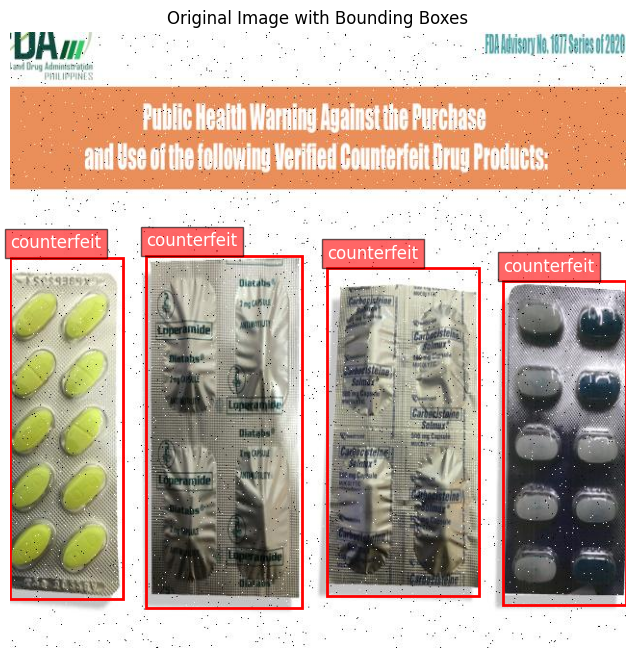

In [ ]:
# Draw image with boxes
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)
for x1, y1, x2, y2, class_id in boxes:
    color = 'red' if class_id == 1 else 'green'
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 10, class_names[class_id], color='white', fontsize=12, bbox=dict(facecolor=color, alpha=0.6))
plt.axis('off')
plt.title("Original Image with Bounding Boxes")
plt.show()


#8. Perform Data Augmentation Example

In [ ]:
pip install --upgrade albumentations


In [ ]:
import os
import cv2
import albumentations as A

from tqdm import tqdm

def load_yolo_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.read().strip().split('\n')
    labels = []
    for line in lines:
        parts = list(map(float, line.strip().split()))
        if len(parts) == 5:
            labels.append(parts)
    return labels

def save_yolo_labels(label_path, labels):
    with open(label_path, 'w') as f:
        for label in labels:
            line = ' '.join(map(str, label))
            f.write(f"{line}\n")

def yolo_to_bbox(ann, img_w, img_h):
    cls, x, y, w, h = ann
    x1 = int((x - w / 2) * img_w)
    y1 = int((y - h / 2) * img_h)
    x2 = int((x + w / 2) * img_w)
    y2 = int((y + h / 2) * img_h)
    return [x1, y1, x2, y2], int(cls)

def bbox_to_yolo(bbox, img_w, img_h, cls):
    x1, y1, x2, y2 = bbox
    x_center = ((x1 + x2) / 2) / img_w
    y_center = ((y1 + y2) / 2) / img_h
    width = (x2 - x1) / img_w
    height = (y2 - y1) / img_h
    return [cls, x_center, y_center, width, height]

transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.Blur(blur_limit=3, p=0.3),
    A.GaussNoise(p=0.3),
    A.CLAHE(p=0.2),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomSizedBBoxSafeCrop(width=640, height=640, p=0.5),
    A.CoarseDropout(
        max_holes=8,
        max_height=20,
        max_width=20,
        fill_value=0,
        p=0.5
    )

], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.4, check_each_transform=True))

image_dir = 'pill_dataset/train/images'
label_dir = 'pill_dataset/train/labels'
aug_img_dir = 'pill_dataset/train/images_aug'
aug_lbl_dir = 'pill_dataset/train/labels_aug'

os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_lbl_dir, exist_ok=True)

print("[INFO] Starting strong augmentation...")

for filename in tqdm(os.listdir(image_dir)):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    image_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")
    if not os.path.exists(label_path):
        continue

    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    labels = load_yolo_labels(label_path)

    if all(int(label[0]) != 1 for label in labels):
        continue

    converted_bboxes = []
    class_labels = []
    for ann in labels:
        bbox, cls = yolo_to_bbox(ann, w, h)
        converted_bboxes.append(bbox)
        class_labels.append(cls)

    augmentations_per_image = 3  # Increase this number for more aggressive augmentation

    for i in range(augmentations_per_image):
        try:
            augmented = transform(image=image, bboxes=converted_bboxes, class_labels=class_labels)
            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_classes = augmented['class_labels']

            yolo_bboxes = [bbox_to_yolo(bbox, w, h, cls) for bbox, cls in zip(aug_bboxes, aug_classes)]

            out_img_name = os.path.splitext(filename)[0] + f"_aug{i}.jpg"
            out_lbl_name = os.path.splitext(filename)[0] + f"_aug{i}.txt"

            cv2.imwrite(os.path.join(aug_img_dir, out_img_name), aug_img)
            save_yolo_labels(os.path.join(aug_lbl_dir, out_lbl_name), yolo_bboxes)
        except Exception as e:
            print(f"[ERROR] {filename}: {e}")

print("[✅ DONE] Strong augmentation completed.")

/tmp/ipython-input-4095872926.py:49: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


[INFO] Starting strong augmentation...


  4%|▍         | 158/4101 [00:01<00:19, 199.43it/s]

[ERROR] FDA-Advisory-No-2021-0607_png.rf.b5516674da25fef3d34bbc973c893735.jpg: x_max is less than or equal to x_min for bbox [0.46875  0.828125 0.46875  0.853125 1.      ].
[ERROR] FDA-Advisory-No-2021-0607_png.rf.b5516674da25fef3d34bbc973c893735.jpg: x_max is less than or equal to x_min for bbox [0.46875  0.828125 0.46875  0.853125 1.      ].
[ERROR] FDA-Advisory-No-2021-0607_png.rf.b5516674da25fef3d34bbc973c893735.jpg: x_max is less than or equal to x_min for bbox [0.46875  0.828125 0.46875  0.853125 1.      ].


100%|██████████| 4101/4101 [00:18<00:00, 226.05it/s]

[✅ DONE] Strong augmentation completed.


In [ ]:
import os

# Adjust these paths as needed
label_dirs = [
    'pill_dataset/train/labels',
    'pill_dataset/train/labels_aug'
]

authentic_count = 0
counterfeit_count = 0

for label_dir in label_dirs:
    if not os.path.exists(label_dir):
        continue
    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                class_id = int(float(parts[0]))
                if class_id == 0:
                    authentic_count += 1
                elif class_id == 1:
                    counterfeit_count += 1
print("After argumentation")
print("Authentic pills:", authentic_count)
print("Counterfeit pills:", counterfeit_count)


After argumentation
Authentic pills: 7068
Counterfeit pills: 2254


In [ ]:
#Move the augmented files into the main folders
import shutil
import os

for src_dir, dst_dir in [
    ('pill_dataset/train/images_aug', 'pill_dataset/train/images'),
    ('pill_dataset/train/labels_aug', 'pill_dataset/train/labels')
]:
    for file in os.listdir(src_dir):
        dst_file = os.path.join(dst_dir, file)
        if os.path.exists(dst_file):
            os.remove(dst_file)
        shutil.move(os.path.join(src_dir, file), dst_dir)

Install YOLOv8 Library

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
from ultralytics import YOLO

# Path to your data.yaml
data_yaml = 'pill_dataset/data.yaml'

# Path to pre-trained model (use 'yolov8n.pt', 'yolov8s.pt', etc.)
pretrained = 'yolov8n.pt'

# Initialize model
model = YOLO(pretrained)


model.train(
    data='pill_dataset/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    patience=20,
    plots=True,
    box=7.5,
    cls=0.5,
    dfl=1.5,
    device='cpu'
)

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pill_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

train: Scanning /content/pill_dataset/train/labels.cache... 4602 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4602/4602 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 403.4±75.6 MB/s, size: 37.8 KB)


val: Scanning /content/pill_dataset/valid/labels.cache... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<?, ?it/s]

Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G     0.7614      1.405      1.198         62        640:  92%|█████████▏| 265/288 [59:55<05:06, 13.32s/it]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from ultralytics import YOLO
model = YOLO('runs/detect/train2/weights/best.pt')
metrics = model.val(data='pill_dataset/data.yaml')
print(metrics)

ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
from ultralytics import YOLO

model = YOLO('runs/detect/train2/weights/best.pt')  # apne trained model ka path
results = model.predict(source='/content/Screenshot 1.jpg', save=True)

In [ ]:
import os
print(os.listdir('runs/detect/predict'))



In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/Screenshot 2.jpg'  # Replace with actual filename
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
from ultralytics import YOLO

model = YOLO('runs/detect/train2/weights/best.pt')  # apne trained model ka path
results = model.predict(source='/content/Screenshot 1.jpg', save=True)

In [ ]:
image_path = '/content/runs/detect/predict2/Screenshot 1.jpg'  # Replace with actual filename
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
import os
from PIL import Image, ImageDraw
import numpy as np
import glob

def yolo2bbox(xc, yc, w, h, img_w, img_h):
    x_c = xc * img_w
    y_c = yc * img_h
    w = w * img_w
    h = h * img_h
    x_min = int(max(x_c - w/2, 0))
    y_min = int(max(y_c - h/2, 0))
    x_max = int(min(x_c + w/2, img_w-1))
    y_max = int(min(y_c + h/2, img_h-1))
    return x_min, y_min, x_max, y_max

def make_mask(label_file, img_size=(640,640), class_map={0:1, 1:2}):
    mask = Image.new('L', img_size, 0)
    draw = ImageDraw.Draw(mask)
    with open(label_file, 'r') as lf:
        for line in lf:
            parts = line.strip().split()
            if len(parts) != 5: continue
            cls, x, y, w, h = map(float, parts)
            x_min, y_min, x_max, y_max = yolo2bbox(x, y, w, h, *img_size)
            draw.rectangle([x_min, y_min, x_max, y_max], fill=class_map[int(cls)])
    return np.array(mask)

def convert_all_labels_to_masks(labels_dir, images_dir, masks_dir):
    os.makedirs(masks_dir, exist_ok=True)
    for label_path in glob.glob(os.path.join(labels_dir, '*.txt')):
        base = os.path.splitext(os.path.basename(label_path))[0]
        mask = make_mask(label_path, img_size=(640, 640), class_map={0:1, 1:2})
        mask_img = Image.fromarray(mask)
        mask_img.save(os.path.join(masks_dir, f'{base}.png'))
    print("Conversion complete for:", masks_dir)

# Example for train split
convert_all_labels_to_masks(
    labels_dir='pill_dataset/train/labels',
    images_dir='pill_dataset/train/images',
    masks_dir='pill_dataset/train/masks'
)
